In [118]:
!pip install numpy pandas simpleitk matplotlib 

Defaulting to user installation because normal site-packages is not writeable


In [97]:
import SimpleITK as sitk
import matplotlib.pylab as plt
import os
import pandas as pd
import numpy as np

def visualize(image, label):
    plt.figure(figsize=(8,8))
    plt.imshow(image, cmap='gray')

    alpha = label.copy()
    alpha[alpha>0] = 1
    plt.imshow(label, alpha=alpha, cmap='jet')
    plt.axis('off')
    plt.show()


TRAIN_IMAGES = 'nnUNet_raw_data_base/nnUNet_raw_data/Task500_BrainTumor/imagesTr'
TRAIN_LABELS = 'nnUNet_raw_data_base/nnUNet_raw_data/Task500_BrainTumor/labelsTr'
TEST_IMAGES = 'nnUNet_raw_data_base/nnUNet_raw_data/Task500_BrainTumor/imagesTs'
TEST_LABELS = 'nnUNet_raw_data_base/nnUNet_raw_data/Task500_BrainTumor/labelsTs'

train_ids = [int(fpath.split('_')[1].split('.')[0]) for fpath in os.listdir(TRAIN_IMAGES) if fpath.endswith('.nii.gz')]
train_ids.sort()

test_ids = [int(fpath.split('_')[1].split('.')[0]) for fpath in os.listdir(TEST_IMAGES) if fpath.endswith('.nii.gz')]
test_ids.sort()

print(len(train_ids), 'train', len(test_ids), 'test') 
print('file_id examples:', train_ids[:30])

3360 train 380 test
file_id examples: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177]


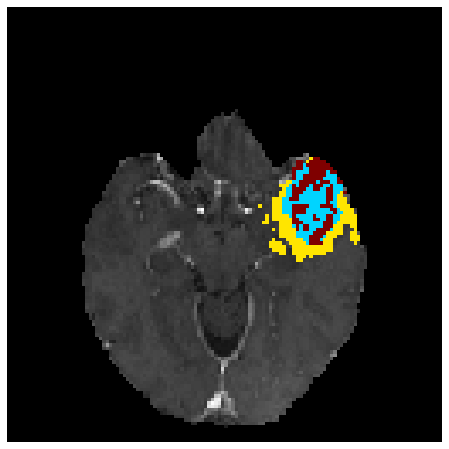

In [6]:
id = 0 # set this to the image/subject ID

image = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(TRAIN_IMAGES, f"BRATS_{str(id).zfill(5)}_0000.nii.gz"), sitk.sitkFloat32)).squeeze()
label = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(TRAIN_LABELS, f"BRATS_{str(id).zfill(5)}.nii.gz"), sitk.sitkFloat32)).squeeze()

visualize(image, label)

Trained model means              casename  whole tumor  tumor core  enhancing tumor
3362  mean (nan is 1)       0.9255      0.9084           0.9248


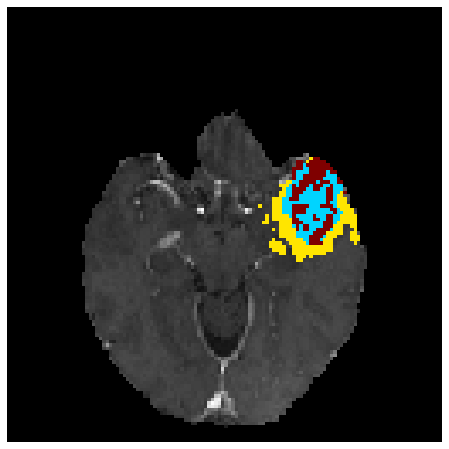

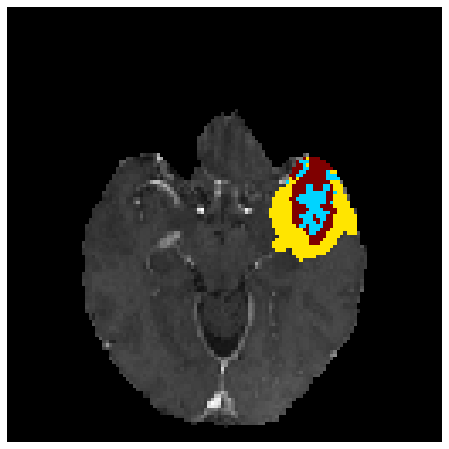

,casename,whole tumor,tumor core,enhancing tumor
0,BRATS_00000,0.9421,0.8105,0.8731


In [40]:
# id = 0

# PRED_LABELS = 'nnUNet_trained_models/nnUNet/2d/Task500_BrainTumor/nnUNetTrainerV2BraTSRegions__nnUNetPlansv2.1/all/validation_raw'
# test_summary_df = pd.read_csv(f'{PRED_LABELS}/summary.csv')
# print('Trained model means', test_summary_df[-2:-1])

# image = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(TRAIN_IMAGES, f"BRATS_{str(id).zfill(5)}_0000.nii.gz"), sitk.sitkFloat32)).squeeze()
# label = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(TRAIN_LABELS, f"BRATS_{str(id).zfill(5)}.nii.gz"), sitk.sitkFloat32)).squeeze()
# pred_label = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(PRED_LABELS, f"BRATS_{str(id).zfill(5)}.nii.gz"), sitk.sitkFloat32)).squeeze()

# visualize(image, label)
# visualize(image, pred_label)
# test_summary_df[test_summary_df['casename']==f'BRATS_{str(id).zfill(5)}']

### Metrics

In [117]:
from nnunet.evaluation.evaluator import *
from nnunet.evaluation.region_based_evaluation import *
import pandas as pd

print('get fold 0 training metrics')

df_list_train = []

for TRAINER_CLASS in ["nnUNetTrainerV2BraTSRegions", "nnUNetTrainerV2BraTSRegions_DA3_BN_BD", "nnUNetTrainerV2BraTSRegions_DA4_BN_BD"]:
    train_summary_csv = f"nnUNet_trained_models/nnUNet/2d/Task500_BrainTumor/{TRAINER_CLASS}__nnUNetPlansv2.1/fold_0/validation_raw/summary.csv"
    train_summary_df = pd.read_csv(train_summary_csv)
    
    print(TRAINER_CLASS)
    print(train_summary_df[-2:-1])
    
    df_list_train.append([TRAINER_CLASS]+list(train_summary_df[-2:-1].values[0][1:]))
    
    train_summary_df.to_csv(f'results/{TRAINER_CLASS}_train_fold0_regions_summary.csv')
    
    
REF_PATH = "nnUNet_raw_data_base/nnUNet_raw_data/Task500_BrainTumor/labelsTs"
PRED_PATH_MAIN = "nnUNet_raw_data_base/nnUNet_raw_data/Task500_BrainTumor/predTs"

df_list_test = []

print('\n=========================\nTEST SET')

for TRAINER_CLASS in ["nnUNetTrainerV2_mlia", "nnUNetTrainerV2BraTSRegions", "nnUNetTrainerV2BraTSRegions_DA3_BN_BD", "nnUNetTrainerV2BraTSRegions_DA4_BN_BD"]:
    PRED_PATH = f'{PRED_PATH_MAIN}_{TRAINER_CLASS}'
#     res = evaluate_folder(REF_PATH, PRED_PATH, [1, 2, 3]) # evaluate all but background
#     print(res)
    
    evaluate_regions(PRED_PATH, REF_PATH, get_brats_regions())
    
    test_summary_df = pd.read_csv(f'{PRED_PATH}/summary.csv')
    
    print(TRAINER_CLASS)
    print(test_summary_df[-2:-1])
    
    df_list_test.append([TRAINER_CLASS]+list(test_summary_df[-2:-1].values[0][1:]))

    test_summary_df.to_csv(f'results/{TRAINER_CLASS}_test_regions_summary.csv')

pd.DataFrame(df_list_train, columns=['trainer_class','whole tumor','tumor core','enhancing tumor']).to_csv('train_metrics.csv')
pd.DataFrame(df_list_test, columns=['trainer_class','whole tumor','tumor core','enhancing tumor']).to_csv('test_metrics.csv')

get fold 0 training metrics
nnUNetTrainerV2BraTSRegions
            casename  whole tumor  tumor core  enhancing tumor
674  mean (nan is 1)       0.8763      0.8574           0.8936
nnUNetTrainerV2BraTSRegions_DA3_BN_BD
            casename  whole tumor  tumor core  enhancing tumor
674  mean (nan is 1)       0.8729      0.8532           0.8976
nnUNetTrainerV2BraTSRegions_DA4_BN_BD
            casename  whole tumor  tumor core  enhancing tumor
674  mean (nan is 1)       0.8767      0.8574           0.9031

TEST SET
nnUNetTrainerV2_mlia
            casename  whole tumor  tumor core  enhancing tumor
382  mean (nan is 1)       0.6266      0.5938           0.8001
nnUNetTrainerV2BraTSRegions
            casename  whole tumor  tumor core  enhancing tumor
382  mean (nan is 1)       0.6167      0.5891           0.8135
nnUNetTrainerV2BraTSRegions_DA3_BN_BD
            casename  whole tumor  tumor core  enhancing tumor
382  mean (nan is 1)       0.6497      0.6193           0.8106
nnUNetTrainerV2

### Test Set Predictions - Visualize

In [45]:
PRED_PATH_MAIN = "nnUNet_raw_data_base/nnUNet_raw_data/Task500_BrainTumor/predTs"

PRED_PATHS = []
for TRAINER_CLASS in ["nnUNetTrainerV2_mlia", "nnUNetTrainerV2BraTSRegions", "nnUNetTrainerV2BraTSRegions_DA3_BN_BD", "nnUNetTrainerV2BraTSRegions_DA4_BN_BD"]:
    PRED_PATH = f'{PRED_PATH_MAIN}_{TRAINER_CLASS}'
    print(PRED_PATH)
    PRED_PATHS.append(PRED_PATH)
    
PRED_LABELS = PRED_PATHS[-1] # selecting last - the best
test_summary_df = pd.read_csv(f'{PRED_LABELS}/summary.csv')
print(test_summary_df[-2:-1])

nnUNet_raw_data_base/nnUNet_raw_data/Task500_BrainTumor/predTs_nnUNetTrainerV2_mlia
nnUNet_raw_data_base/nnUNet_raw_data/Task500_BrainTumor/predTs_nnUNetTrainerV2BraTSRegions
nnUNet_raw_data_base/nnUNet_raw_data/Task500_BrainTumor/predTs_nnUNetTrainerV2BraTSRegions_DA3_BN_BD
nnUNet_raw_data_base/nnUNet_raw_data/Task500_BrainTumor/predTs_nnUNetTrainerV2BraTSRegions_DA4_BN_BD
            casename  whole tumor  tumor core  enhancing tumor
382  mean (nan is 1)       0.6587      0.6288           0.8193


In [99]:
def visualize_side(image, label, pred_label, title=''):
    plt.figure(figsize=(21,7))
    
    plt.subplot(1,3,1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1,3,2)
    plt.imshow(label, cmap='jet')
    plt.axis('off')
    plt.title(title, fontsize=18)
    
    plt.subplot(1,3,3)
    plt.imshow(pred_label, cmap='jet')
    plt.axis('off')
    
    plt.show()

32088


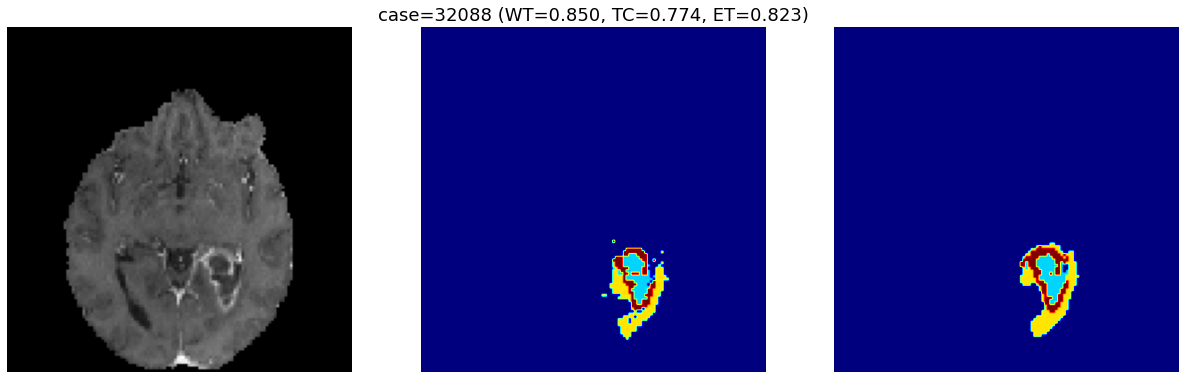

32256


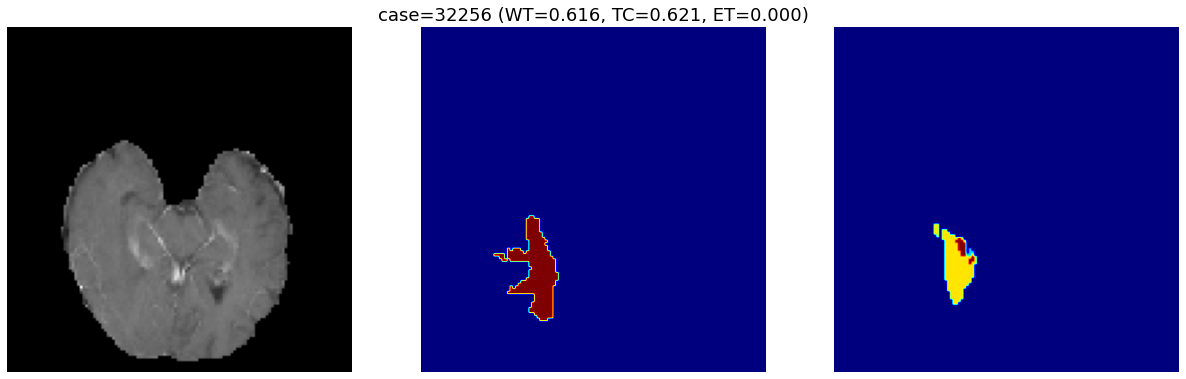

32424


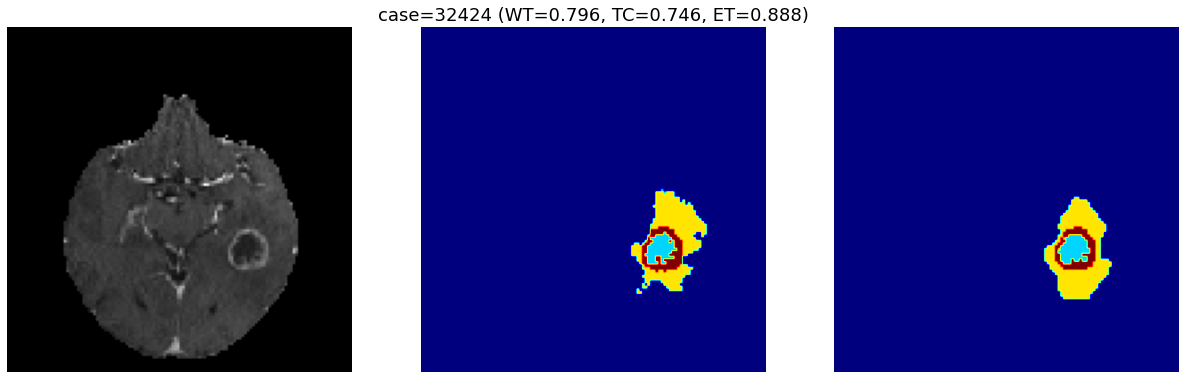

32592


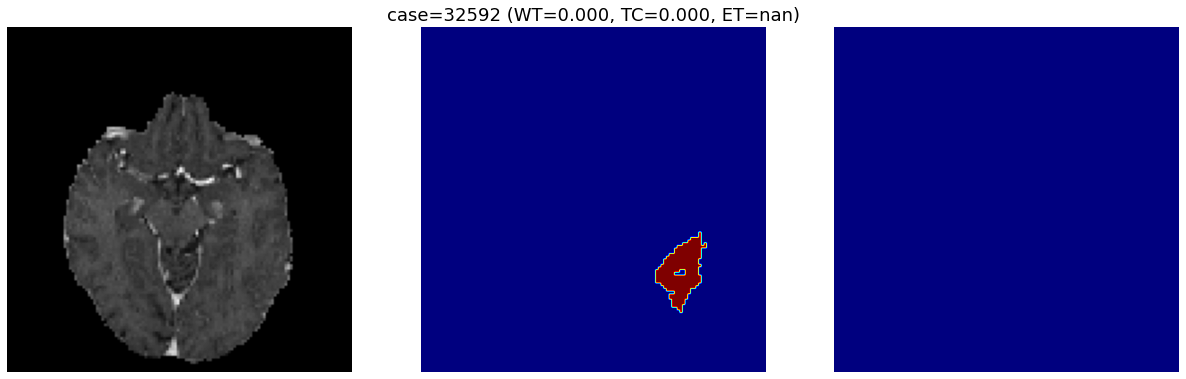

32760


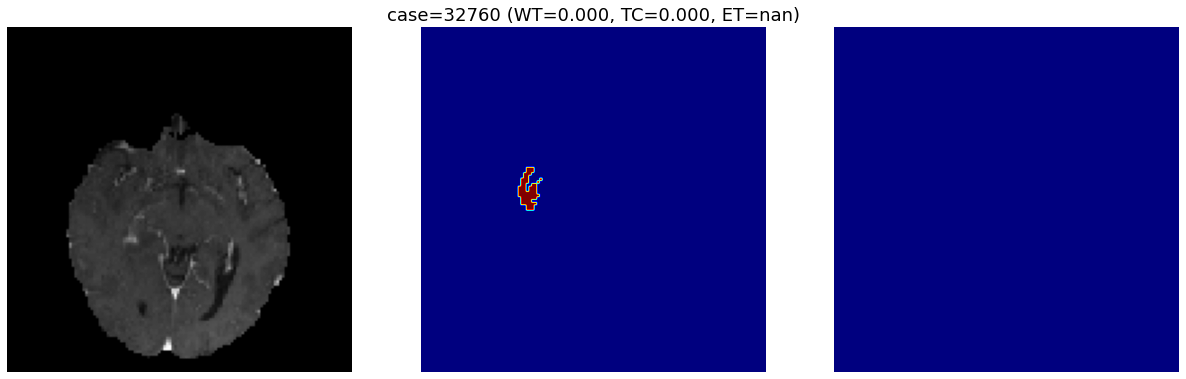

32928


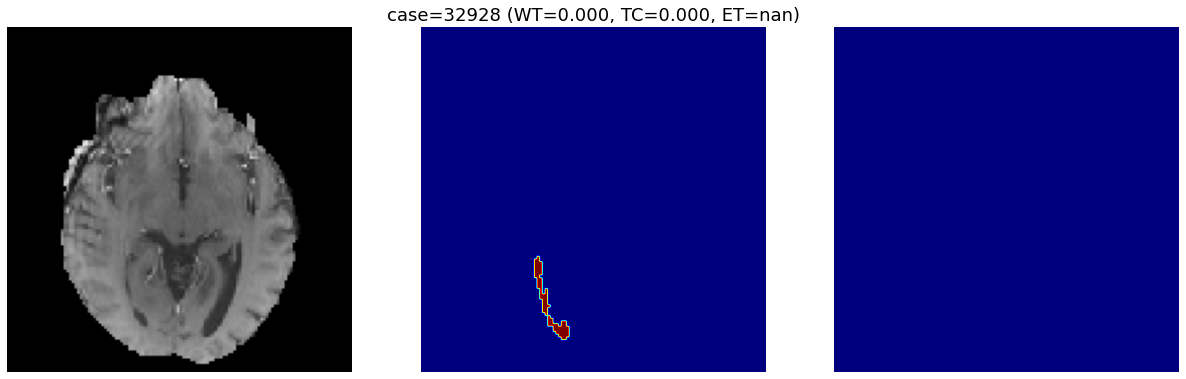

33096


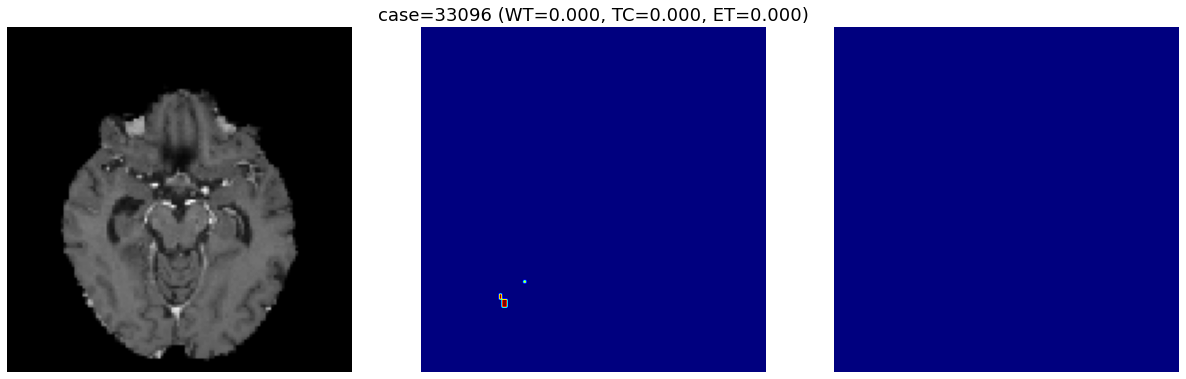

33264


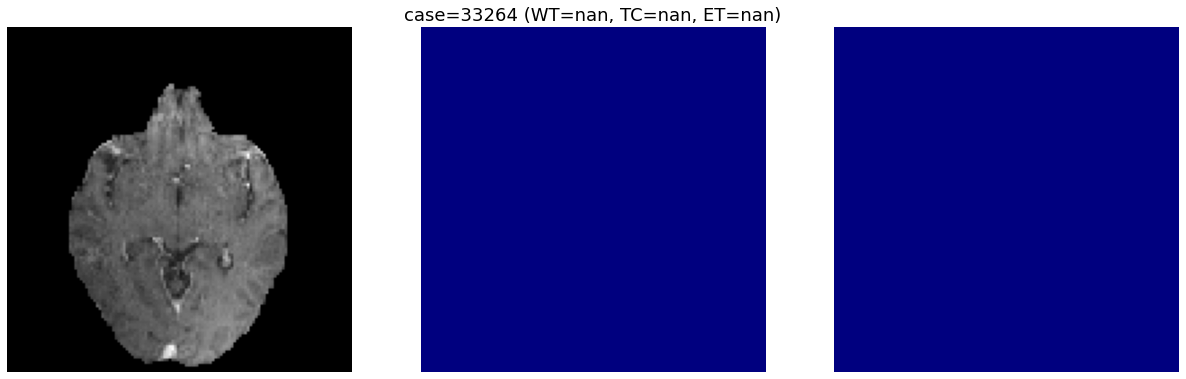

33432


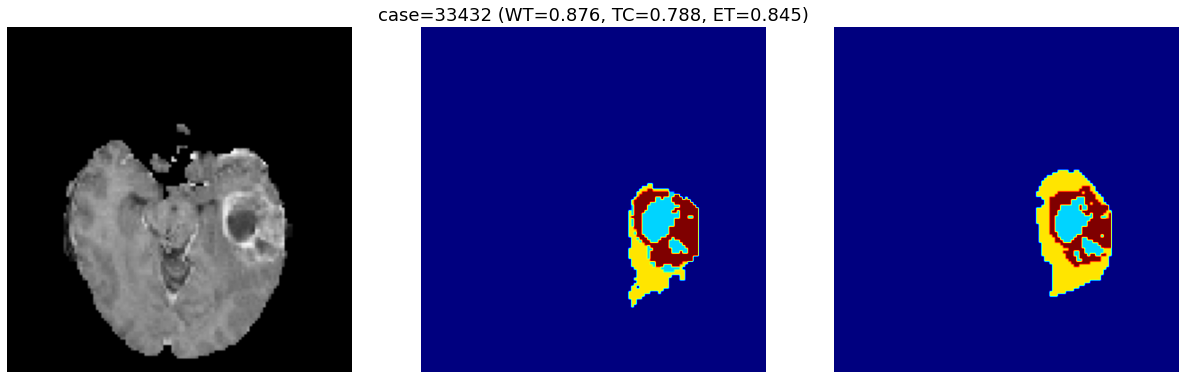

33600


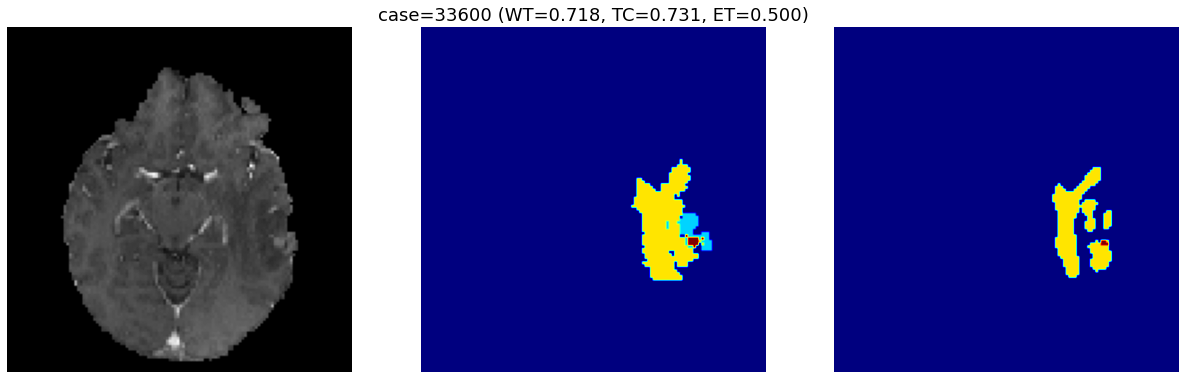

33768


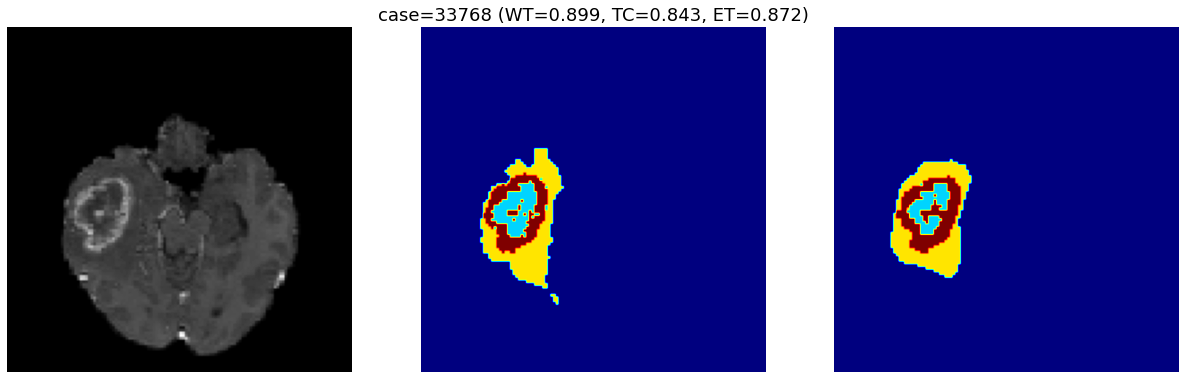

33936


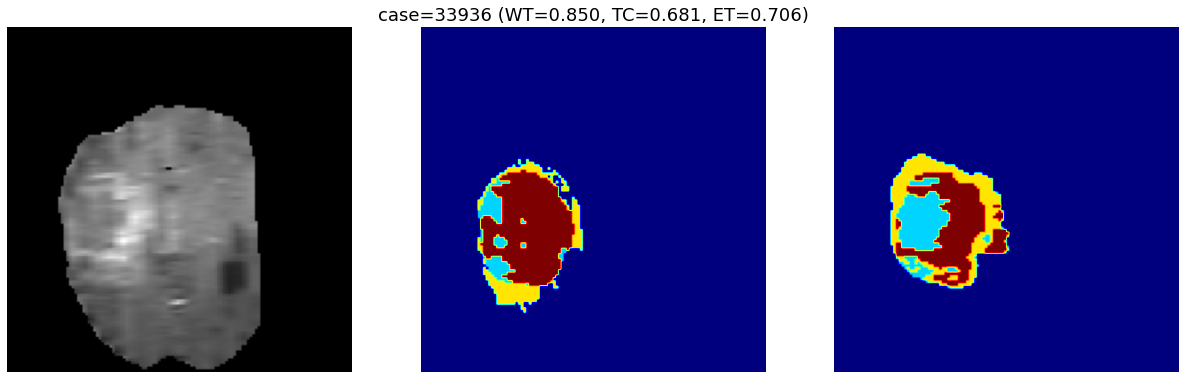

34104


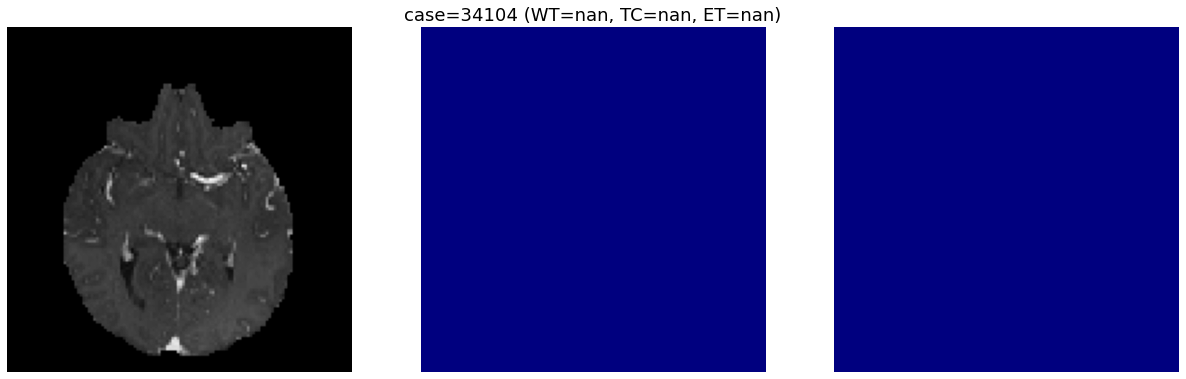

34272


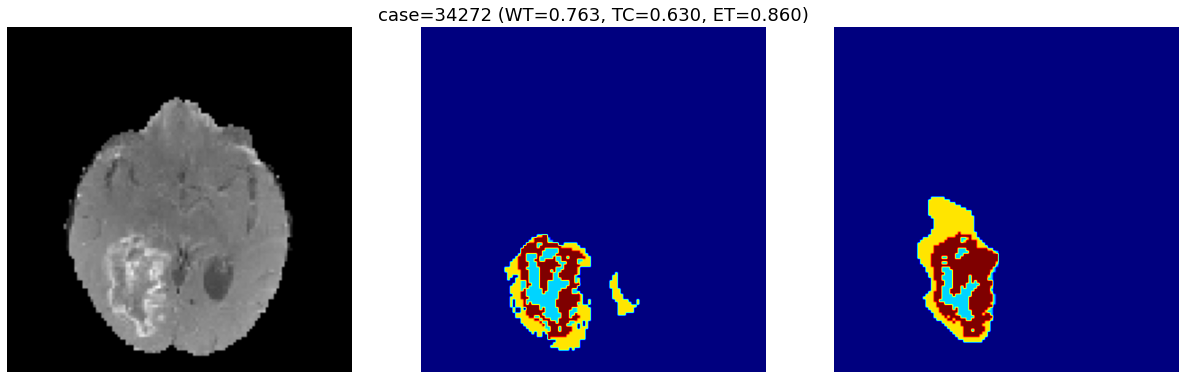

34440


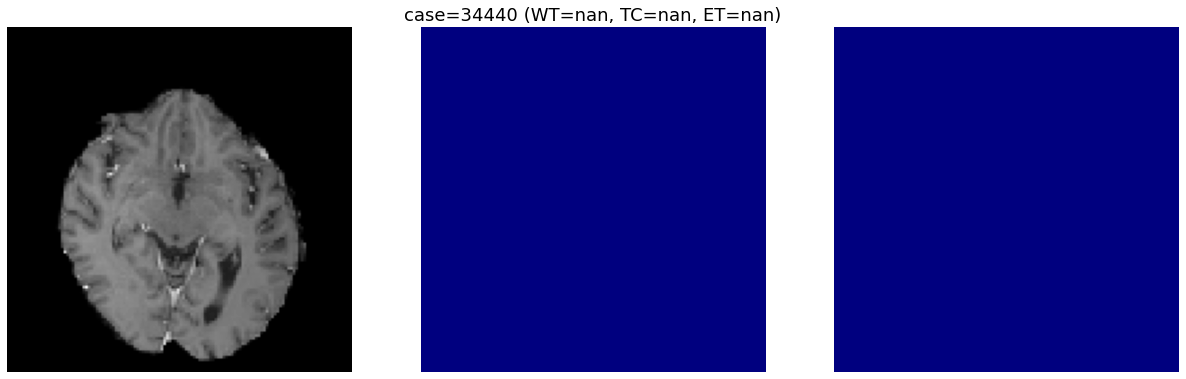

34608


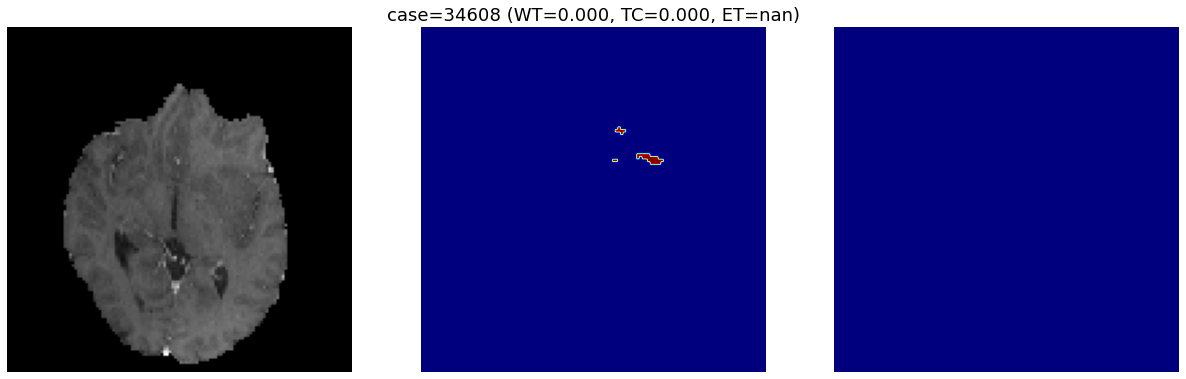

34776


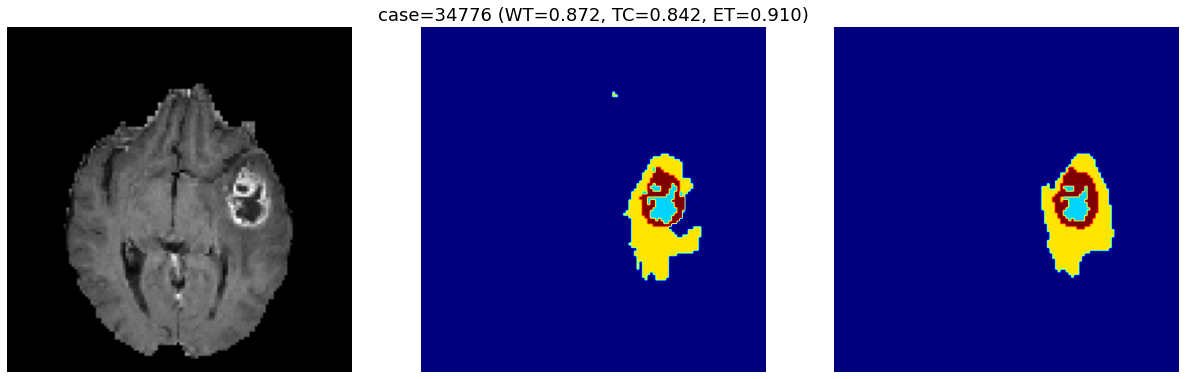

34944


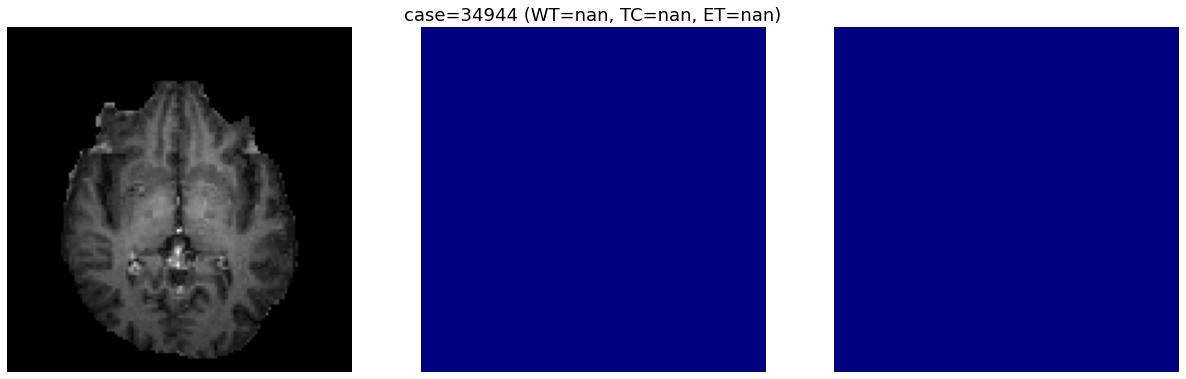

35112


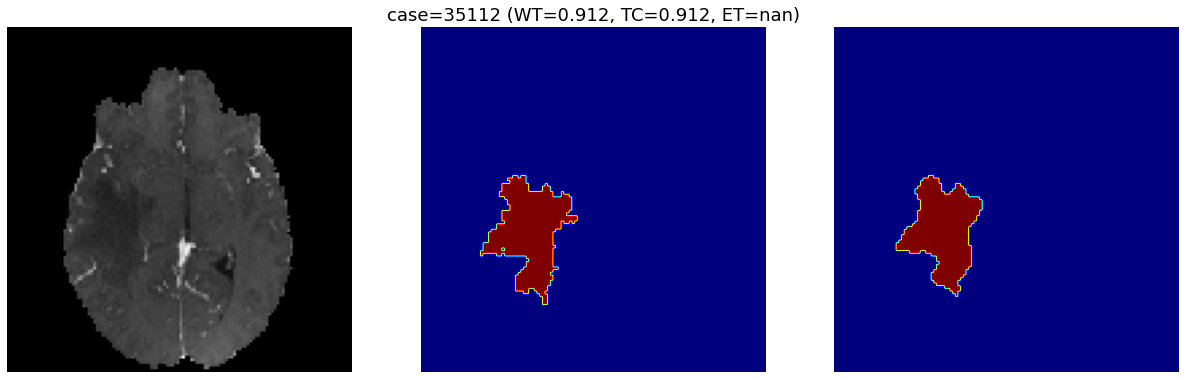

In [101]:
for i in range(0, len(test_ids), 20):
    id = test_ids[i]
    print(id)
    
    image = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(TEST_IMAGES, f"BRATS_{str(id).zfill(5)}_0000.nii.gz"), sitk.sitkFloat32)).squeeze()
    label = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(TEST_LABELS, f"BRATS_{str(id).zfill(5)}.nii.gz"), sitk.sitkFloat32)).squeeze()
    pred_label = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(PRED_LABELS, f"BRATS_{str(id).zfill(5)}.nii.gz"), sitk.sitkFloat32)).squeeze()
    
    metrics = test_summary_df[test_summary_df['casename']==f'BRATS_{str(id).zfill(5)}']
    m = metrics.values[0][1:].astype(np.float32)
#     m[np.isnan(m)] = 1
    title = f'case={id} (WT={m[0]:.3f}, TC={m[1]:.3f}, ET={m[2]:.3f})'

    visualize_side(image, label, pred_label, title)